In [1]:
import numpy as np
from examples.seismic import TimeAxis, demo_model
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as plticker
from examples.seismic.ttipure import PureTtiWaveSolver
from devito import Function, norm, info
from utils import setup_geometry, plotTimeSlices

In [2]:
def tti_setup(shape=(50, 50, 50), spacing=(20.0, 20.0, 20.0), tn=250.0,
              space_order=4, nbl=10, preset='layers-tti',
              **kwargs):

    # Two layer model for true velocity
    model = demo_model(preset, shape=shape, spacing=spacing,
                       space_order=space_order, nbl=nbl, **kwargs)

    # Source and receiver geometries
    geometry = setup_geometry(model, tn)

    return PureTtiWaveSolver(model, geometry, space_order=space_order,
                             **kwargs), model

In [3]:
def run(solver, save=False):

    info("Applying Forward")
    # Whether or not we save the whole time history. We only need the full wavefield
    # with 'save=True' if we compute the gradient without checkpointing, if we use
    # checkpointing, PyRevolve will take care of the time history
    # Define receiver geometry (spread across x, just below surface)
    rec, u, summary = solver.forward(save=save)

    return rec, u

In [4]:
shape = (101, 101, 101)
spacing = (20., 20., 20.)
origin = (0.,0.,0.)
tn = 850.0
nbl = 10

solver, model = tti_setup(shape=shape, spacing=spacing, nbl=nbl, tn=tn, preset='constant-tti')

dt = model.critical_dt

rec, u = run(solver, save=True)

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_epsilon` ran in 0.01 s
Operator `pad_delta` ran in 0.01 s
Operator `pad_theta` ran in 0.01 s
Operator `pad_phi` ran in 0.01 s
Applying Forward
Operator `ForwardTTI` ran in 0.79 s


In [16]:
u.shape

(180, 121, 121, 121)

In [15]:
u.dimensions

(time, x, y, z)

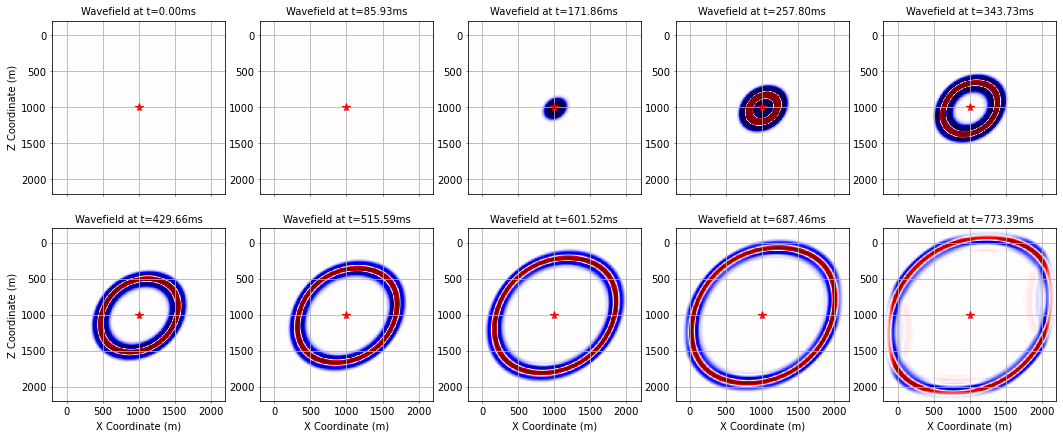

In [5]:
plotTimeSlices (model, u)

In [30]:
import plotly.graph_objects as go

def get_the_slice(x,y,z, surfacecolor):
    return go.Surface(x=x,
                      y=y,
                      z=z,
                      surfacecolor=surfacecolor,
                      coloraxis='coloraxis')

In [31]:
def get_lims_colors(surfacecolor):# color limits for a slice
    return np.min(surfacecolor), np.max(surfacecolor)

In [47]:
#time index of layered model --> 116,145,174
#time index of constant model --> 55,66,77

# z planes
x = np.linspace(0,200, shape[0])
y = np.linspace(0,200, shape[1])
x, y = np.meshgrid(x,y)
z = np.ones(x.shape)*100
#
maxz=np.max(np.abs(u.data[100,:,:,shape[2]//2]))
maxy=np.max(np.abs(u.data[100,:,shape[1]//2,:]))
amax=max([maxz,maxy])
#
surfcolor_z = np.array(u.data[100,:,:,shape[2]//2])/amax
surfcolor_z1 = np.array(u.data[110,:,:,shape[2]//2])/amax
surfcolor_z2 = np.array(u.data[120,:,:,shape[2]//2])/amax
#
sminz, smaxz = get_lims_colors(surfcolor_z)
sminz1, smaxz1 = get_lims_colors(surfcolor_z1)
sminz2, smaxz2 = get_lims_colors(surfcolor_z2)
#
slice_z = get_the_slice(x, y, z, surfcolor_z)
slice_z1 = get_the_slice(x, y, z, surfcolor_z1)
slice_z2 = get_the_slice(x, y, z, surfcolor_z2)

In [48]:
# y planes
x = np.linspace(0,200, shape[0])
z = np.linspace(0,200, shape[1])
x, z = np.meshgrid(x,z)
y = np.ones(x.shape)*100
#
surfcolor_y = np.array(u.data[100,:,shape[1]//2,:].T)/amax
surfcolor_y1 = np.array(u.data[110,:,shape[1]//2,:].T)/amax
surfcolor_y2 = np.array(u.data[120,:,shape[1]//2,:].T)/amax
#
sminy, smaxy = get_lims_colors(surfcolor_y)
sminy1, smaxy1 = get_lims_colors(surfcolor_y1)
sminy2, smaxy2 = get_lims_colors(surfcolor_y2)
#
slice_y = get_the_slice(x, y, z, surfcolor_y)
slice_y1 = get_the_slice(x, y, z, surfcolor_y1)
slice_y2 = get_the_slice(x, y, z, surfcolor_y2)

In [49]:
vmin = min([sminz, sminz1, sminz2, sminy, sminy1, sminy2])
vmax = max([smaxz, smaxz1, smaxz2, smaxy, smaxy1, smaxy2])
vmin = -vmax
print(vmin, vmax)
#
vmin=-1
vmax=+1

-1.0 1.0


In [50]:
def colorax(vmin, vmax):
    return dict(cmin=vmin,
                cmax=vmax)

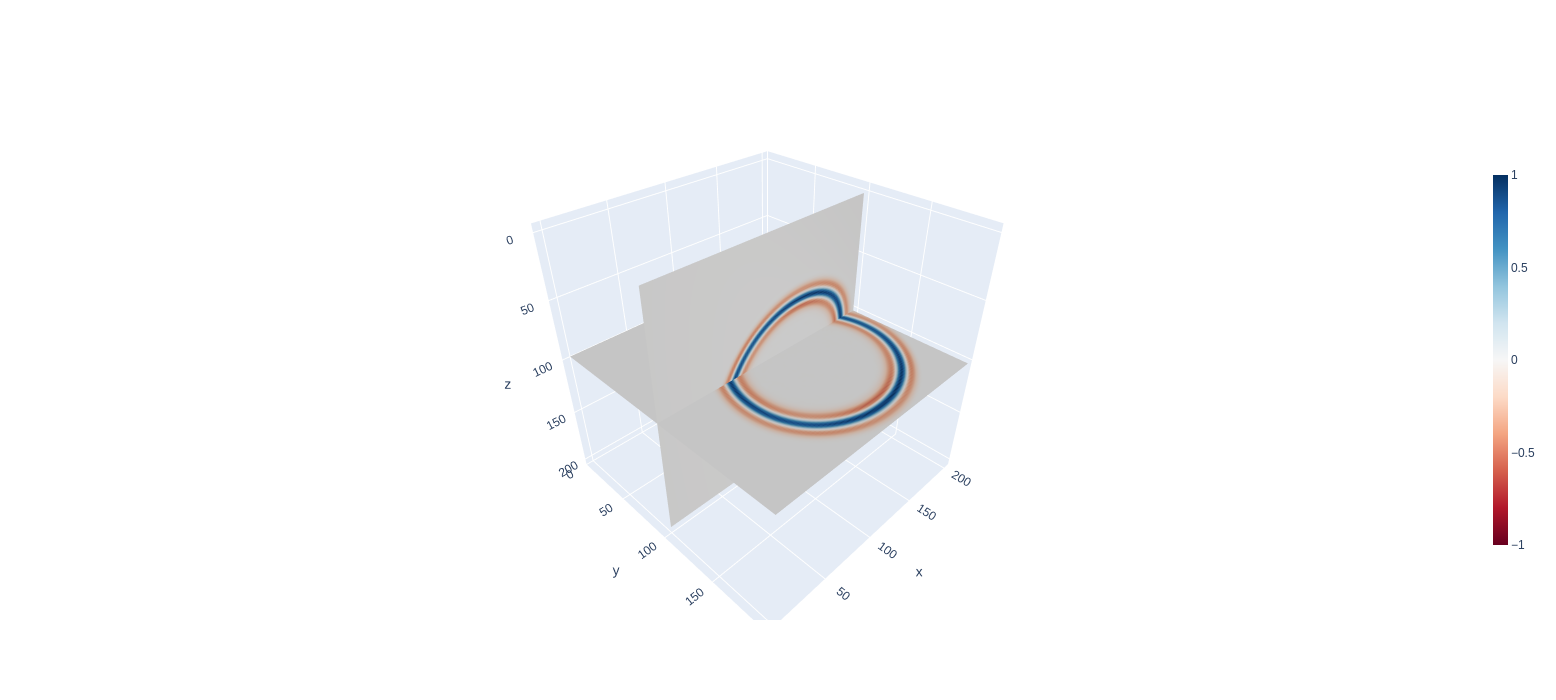

In [51]:
fig1 = go.Figure(data=[slice_z, slice_y])
fig1.update_layout(
    # title_text='Snaps at t=122.82 msec',
    # scene_camera_eye=dict(x=1.87, y=0.88, z=-1.64),
    # title_x=0.5,
    width=700,
    height=700,
    scene = dict(
    xaxis = dict(nticks=6, range=[0,200],),
                 yaxis = dict(nticks=6, range=[0,200],),
                 zaxis = dict(nticks=6, range=[0,200],),
                 xaxis_autorange='reversed',
                 zaxis_autorange='reversed'),
    coloraxis=dict(colorscale='rdbu',
                   colorbar_thickness=15,
                   colorbar_len=0.75,
                   **colorax(vmin, vmax)))                 
fig1.show() 